In [1]:
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader

# Custom imports
import config
from dataset import AugmentedImageDataset

class AutoEncoder(pl.LightningModule):

    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def training_step(self, batch, batch_idx):
        x = batch
        x_hat = self(x)
        loss = F.mse_loss(x_hat, x)
        self.log('train_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x = batch
        x_hat = self(x)
        loss = F.mse_loss(x_hat, x)
        self.log('test_loss', loss)
        return loss

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

# Initialize the model, criterion and optimizer
model = AutoEncoder()

/Users/ilerisoy/anaconda3/envs/pg/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Takes 1.30 mins to load using 8 workers

In [2]:
from torch.utils.data import random_split

# Define MPS device
device = config.device

# Path to the directory with images
image_dir = "/Users/ilerisoy/Vlisco data/Classics/designs"

# Initialize dataset and dataloader
dataset = AugmentedImageDataset(config)

# Split dataset into training and validation sets
val_size = int(len(dataset) * config.validation_split)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers)



# dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers)

print(f"Number of images in train dataset: {len(train_loader)}")
print(f"Number of batches in train dataset: {len(train_loader)}")
print("=========================================")
print(f"Number of images in validation dataset: {len(val_loader)}")
print(f"Number of batches in validation dataset: {len(val_loader)}")


Loading images...
Number of workers: 8


[ WARN:4@5.681] global grfmt_jpeg2000_openjpeg.cpp:607 readData OpenJPEG2000: Image has unknown or unspecified color space, SRGB is assumed
[ WARN:0@10.651] global grfmt_jpeg2000_openjpeg.cpp:607 readData OpenJPEG2000: Image has unknown or unspecified color space, SRGB is assumed
[ WARN:3@13.223] global grfmt_jpeg2000_openjpeg.cpp:607 readData OpenJPEG2000: Image has unknown or unspecified color space, SRGB is assumed
[ WARN:0@18.434] global grfmt_jpeg2000_openjpeg.cpp:607 readData OpenJPEG2000: Image has unknown or unspecified color space, SRGB is assumed
[ WARN:3@18.486] global grfmt_jpeg2000_openjpeg.cpp:607 readData OpenJPEG2000: Image has unknown or unspecified color space, SRGB is assumed
[ WARN:1@22.097] global grfmt_jpeg2000_openjpeg.cpp:607 readData OpenJPEG2000: Image has unknown or unspecified color space, SRGB is assumed
[ WARN:0@25.987] global grfmt_jpeg2000_openjpeg.cpp:607 readData OpenJPEG2000: Image has unknown or unspecified color space, SRGB is assumed
[ WARN:4@29.66

Images loaded.
Number of images in train dataset: 122
Number of batches in train dataset: 122
Number of images in validation dataset: 31
Number of batches in validation dataset: 31


In [3]:
trainer = pl.Trainer(accelerator=config.accelerator, max_epochs=10)

trainer.fit(model, train_dataloaders=train_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ilerisoy/anaconda3/envs/pg/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 370 K  | train
1 | decoder | Sequential | 370 K  | train
-----------------------------------------------
741 K     Trainable params
0         Non-trainable params
741 K     Total params
2.966     Total estimated model par

Epoch 9: 100%|██████████| 122/122 [00:26<00:00,  4.55it/s, v_num=6]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 122/122 [00:26<00:00,  4.52it/s, v_num=6]


In [4]:
trainer.test(model, dataloaders=val_loader)

/Users/ilerisoy/anaconda3/envs/pg/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 31/31 [00:02<00:00, 14.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.015769388526678085
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.015769388526678085}]

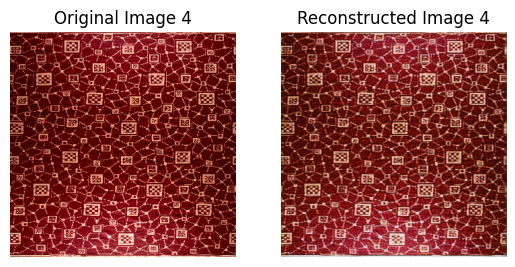

In [7]:
from matplotlib import pyplot as plt

# Get a random index of length batch size
index = torch.randint(0, config.batch_size, (1,)).item()

# Get the first batch of images
images = next(iter(val_loader))

# Get the first image from the batch
image = images[index]

# Get the reconstructed image
reconstructed_image = model(image.unsqueeze(0))

# Plot the original and reconstructed images
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image.permute(1, 2, 0))
ax[0].set_title(f"Original Image {index}")
ax[0].axis("off")
ax[1].imshow(reconstructed_image.squeeze().detach().permute(1, 2, 0))
ax[1].set_title(f"Reconstructed Image {index}")
ax[1].axis("off")
plt.show()



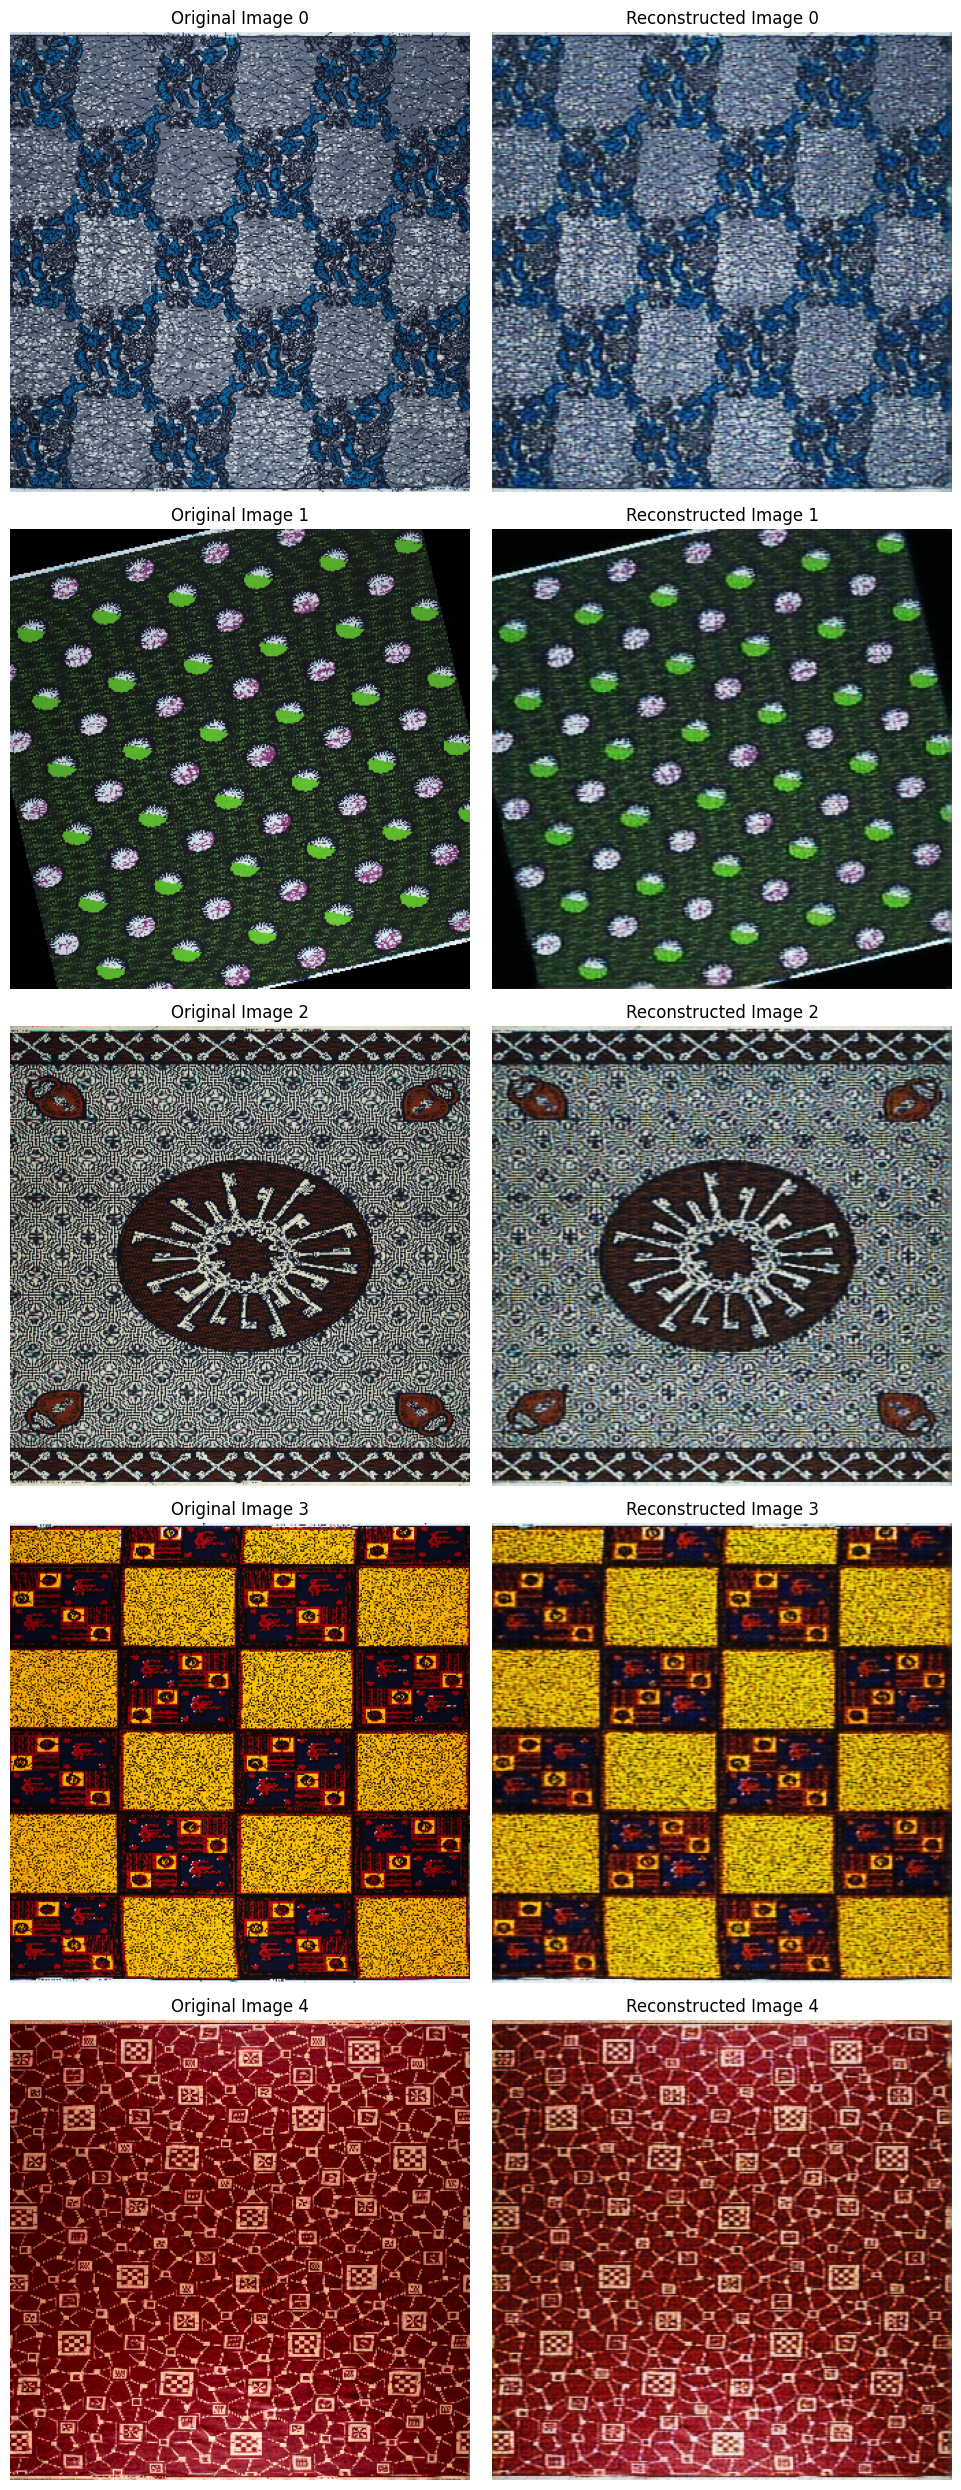

In [9]:
from matplotlib import pyplot as plt
import torch

# Get a batch of images
images = next(iter(val_loader))

# Perform inference on the first 10 images
num_images = 5
fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 5))

for i in range(num_images):
    image = images[i]
    reconstructed_image = model(image.unsqueeze(0))

    # Plot the original image
    axes[i, 0].imshow(image.permute(1, 2, 0))
    axes[i, 0].set_title(f"Original Image {i}")
    axes[i, 0].axis("off")

    # Plot the reconstructed image
    axes[i, 1].imshow(reconstructed_image.squeeze().detach().permute(1, 2, 0))
    axes[i, 1].set_title(f"Reconstructed Image {i}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()